In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import graphviz

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz

트레이닝잡키워드 = pd.read_csv('./data/traingjobkeyword.csv')
del 트레이닝잡키워드['Unnamed: 0']

테스트잡키워드 = pd.read_csv('./data/testjobkeyword.csv')
del 테스트잡키워드['Unnamed: 0']

회사정보 = pd.read_csv('./data/job_companies.csv')
회사정보['companySize'] = 회사정보['companySize'].fillna(0)
회사정보['Size'] = ""

문제 개요(제공 : 프로그래머스)

이 문제는 실제 Programmers 채용 공고 페이지를 방문한 개발자들의 방문/지원 기록을 바탕으로 추천모델을 만들어보는 것이다. 참고로 모든 데이터는 익명화되었음을 밝힌다. 구체적으로 개발자(userID로 표현됨)와 채용공고(jobID로 표현됨)를 보고 개발자가 해당 채용공고에 지원할지 안 할지를 예측하는 Binary Classifier를 만드는 것이다. 이 모델을 만드는데 필요한 feature들은 부가적으로 제공되는 데이터 파일들을 바탕으로 만들어내면 되며 이에 대해서는 뒤의 데이터 세트 섹션에서 설명한다.

# 회사 사이즈별 숫자 부여

In [ ]:
for i in range(len(회사정보)):
    if 회사정보['companySize'][i] == 0 :
        회사정보['Size'][i] = 0 
    elif 회사정보['companySize'][i] == '1-10':
        회사정보['Size'][i] = 1 
    elif 회사정보['companySize'][i] == '11-50':
        회사정보['Size'][i] = 2 
    elif 회사정보['companySize'][i] == '51-100':
        회사정보['Size'][i] = 3
    elif 회사정보['companySize'][i] == '101-200':
        회사정보['Size'][i] = 4
    elif 회사정보['companySize'][i] == '201-500':
        회사정보['Size'][i] = 5
    elif 회사정보['companySize'][i] == '501-1000':
        회사정보['Size'][i] = 6
    elif 회사정보['companySize'][i] == '1000 이상':
        회사정보['Size'][i] = 7

# 각 변수의 회사 사이즈 병합

In [ ]:
트레이닝잡키워드 = 트레이닝잡키워드.merge(회사정보[['jobID','Size']], on='jobID', how = 'left')

In [ ]:
테스트잡키워드 = 테스트잡키워드.merge(회사정보[['jobID','Size']], on='jobID', how = 'left')

# 변수 단어 정리

In [ ]:
for i in range(len(트레이닝잡키워드)):
    트레이닝잡키워드['교집합'][i] = 트레이닝잡키워드['교집합'][i].replace('[','').replace(']','').replace("'",'').replace(' ','').split(',')
    
for i in range(len(테스트잡키워드)):
    테스트잡키워드['교집합'][i] = 테스트잡키워드['교집합'][i].replace('[','').replace(']','').replace("'",'').replace(' ','').split(',')    

D:\programfiles\anaconda3\envs\pythonopencv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
columns = ['ASP.NET','Apache', 'ApacheKafka', 'ApacheSpark', 'Babel', 'DRF(DjangoRESTframework)', 'EmbeddedSystem', 'GCP(GoogleCloudPlatform)',
 'Hibernate', 'JIRA', 'JUnit', 'Jest', 'Keras', 'Laravel', 'MSSQL(MicrosoftSQLServer)', 'MicroserviceArchitecture',
 'NCP(NaverCloudPlatform)', 'NaverCloudPlatform', 'NestJS', 'Next.js', 'NoSQL', 'OpenCV', 'Pandas', 'R', 'RaspberryPi', 'Retrofit',
 'SQLAlchemy', 'SpringDataJPA', 'web3.js']
#테스트 잡키워드에 넣기

In [ ]:
columns2 = ['ApacheSubversion(SVN)', 'Axios', 'JPA(JavaPersistentAPI)', 'ShellScript', 'SpringBatch', 'gRPC'] #트레이닝 잡키워드에 넣기

# ONE-HOT-ENCODING 진행

In [ ]:
a = 트레이닝잡키워드[트레이닝잡키워드['applied'] ==1]
b = 트레이닝잡키워드[트레이닝잡키워드['applied'] ==0].sample(n=857)
result =pd.concat([a,b])
result.merge(트레이닝잡키워드['Size'], left_index =True, right_index = True, how='left')
result.reset_index(inplace =True)
del result['index']

In [ ]:
all_words_df = pd.DataFrame()

for n in range(len(트레이닝잡키워드)):
    words = 트레이닝잡키워드['교집합'][n]
    words_df = pd.DataFrame()
    for i in words:
        words_df[i] = [1]
        #satisfaction.append(df['ratings'].iloc[i])
    all_words_df = pd.concat([all_words_df, words_df], ignore_index=True)

for i in columns2 : 
    all_words_df[i] = np.nan
    
all_words_df.head()   
all_words_df.rename(columns ={"" : 'None'}, inplace = True )
all_words_df  = all_words_df.merge(트레이닝잡키워드['Size'], left_index =True, right_index = True, how='left')
all_words_df = all_words_df.fillna(0)

In [ ]:
all_words_df2 = pd.DataFrame()

for n in range(len(테스트잡키워드)):
    words = 테스트잡키워드['교집합'][n]
    words_df = pd.DataFrame()
    for i in words:
        words_df[i] = [1]
        #satisfaction.append(df['ratings'].iloc[i])
    all_words_df2 = pd.concat([all_words_df2, words_df], ignore_index=True)

for i in columns : 
    all_words_df2[i] = np.nan
    

all_words_df2.rename(columns ={"" : 'None'}, inplace = True )
all_words_df2  = all_words_df2.merge(테스트잡키워드['Size'], left_index =True, right_index = True, how='left')
all_words_df2 = all_words_df2.fillna(0)

# 공평한 applied

In [ ]:
# all_words_df = pd.DataFrame()

# for n in range(len(result)):
#     words = result['교집합'][n]
#     words_df = pd.DataFrame()
#     for i in words:
#         words_df[i] = [1]
#         #satisfaction.append(df['ratings'].iloc[i])
#     all_words_df = pd.concat([all_words_df, words_df], ignore_index=True)

    

# all_words_df.rename(columns ={"" : 'None'}, inplace = True )
# all_words_df  = all_words_df.merge(result['Size'], left_index =True, right_index = True, how='left')
# columns3 = set(all_words_df2) - set(all_words_df)
# for i in columns3:
#     all_words_df[i] = np.nan
# all_words_df = all_words_df.fillna(0)

In [ ]:
all_words_df


,None,MySQL,Android,JavaScript,ReactJS,TypeScript,PHP,Node.js,Java,Django,...,MicroserviceArchitecture,Retrofit,SpringDataJPA,ApacheSubversion(SVN),Axios,JPA(JavaPersistentAPI),ShellScript,SpringBatch,gRPC,Size
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
5996,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
5997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
5998,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


# train_test_split

In [ ]:
X = all_words_df
y = 트레이닝잡키워드['applied'] #
#X = (X - X.min()) / (X.max() - X.min()) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X

,None,MySQL,Android,JavaScript,ReactJS,TypeScript,PHP,Node.js,Java,Django,...,MicroserviceArchitecture,Retrofit,SpringDataJPA,ApacheSubversion(SVN),Axios,JPA(JavaPersistentAPI),ShellScript,SpringBatch,gRPC,Size
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
5996,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
5997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
5998,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


# 의사결정트리 

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
# os.environ[“PATH”] += os.pathsep + ‘C:/Program Files (x86)/Graphviz2.38/bin/’ 
# #Path may vary according to your Graphviz location
# dot_data = export_graphviz(dt, out_file=None, 
#  feature_names=X.columns, 
#  filled=True, rounded=True, 
#  special_characters=True)
# graph = graphviz.Source(dot_data)
# graph

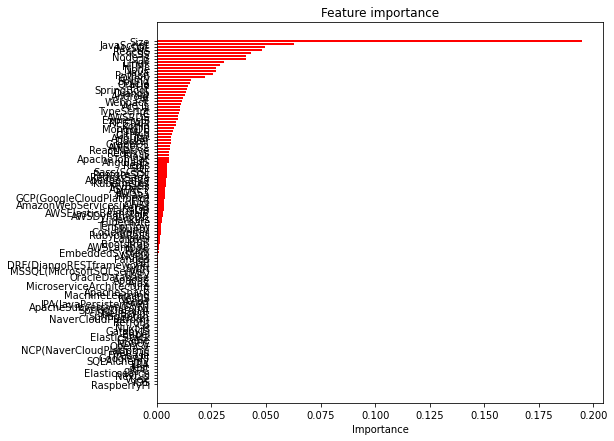

In [ ]:
features_list = X.columns.values
feature_importance = dt.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(8,7))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color ="red")
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importance')
plt.draw()
#plt.savefig("featureimp.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
y_pred_dt = dt.predict(X_test)
print("Decision Tree Classifier report: \n\n", classification_report(y_test, y_pred_dt))
print("Test Accuracy: {}%".format(round(dt.score(X_test, y_test)*100, 2)))

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1035
           1       0.30      0.08      0.13       165

    accuracy                           0.85      1200
   macro avg       0.58      0.53      0.52      1200
weighted avg       0.79      0.85      0.81      1200

Test Accuracy: 84.67%


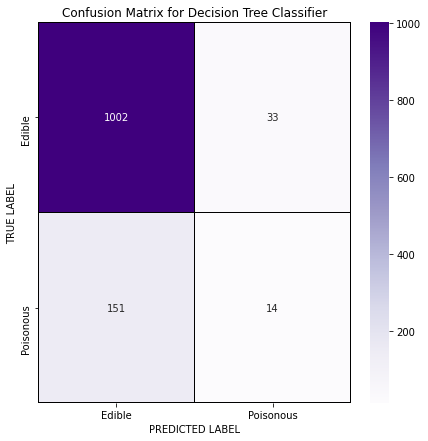

In [ ]:
cm = confusion_matrix(y_test, y_pred_dt)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Decision Tree Classifier')
#plt.savefig("dtcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

# 로지스틱회귀

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs", max_iter=500)
lr.fit(X_train, y_train)
print("Test Accuracy: {}%".format(round(lr.score(X_test, y_test)*100,2)))




Test Accuracy: 86.17%


In [ ]:
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Classifier report: \n\n", classification_report(y_test, y_pred_lr))

Logistic Regression Classifier report: 

               precision    recall  f1-score   support

           0       0.86      1.00      0.93      1035
           1       0.00      0.00      0.00       165

    accuracy                           0.86      1200
   macro avg       0.43      0.50      0.46      1200
weighted avg       0.74      0.86      0.80      1200



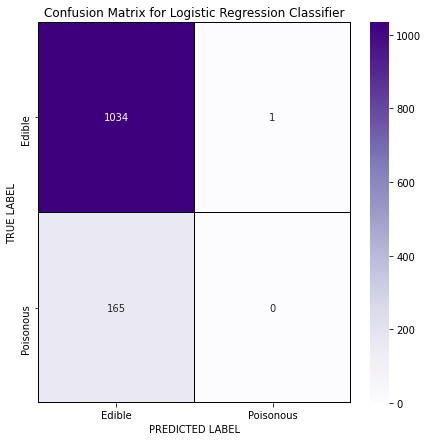

In [ ]:
cm = confusion_matrix(y_test, y_pred_lr)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Logistic Regression Classifier')
#plt.savefig("lrcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
best_Kvalue = 0
best_score = 0
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    if knn.score(X_test, y_test) > best_score:
        best_score = knn.score(X_train, y_train)
        best_Kvalue = i
        
print("Best KNN Value: {}".format(best_Kvalue))
print("Test Accuracy: {}%".format(round(best_score*100,2)))

Best KNN Value: 9
Test Accuracy: 85.35%


In [ ]:
y_pred_knn = knn.predict(X_test)
print("KNN Classifier report: \n\n", classification_report(y_test, y_pred_knn))


KNN Classifier report: 

               precision    recall  f1-score   support

           0       0.87      0.99      0.92      1035
           1       0.45      0.05      0.10       165

    accuracy                           0.86      1200
   macro avg       0.66      0.52      0.51      1200
weighted avg       0.81      0.86      0.81      1200



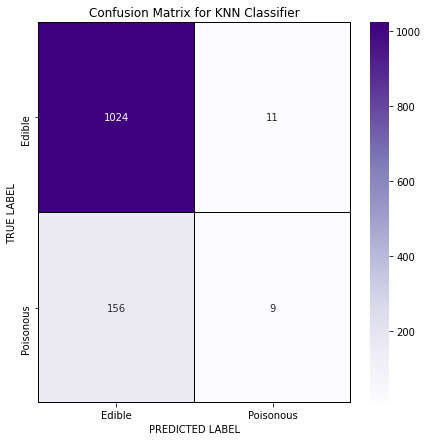

In [ ]:
cm = confusion_matrix(y_test, y_pred_knn)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for KNN Classifier')
#plt.savefig("knncm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

# SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state=42, gamma="auto")
svm.fit(X_train, y_train)
print("Test Accuracy: {}%".format(round(svm.score(X_test, y_test)*100, 2)))


Test Accuracy: 86.25%


In [ ]:
y_pred_svm = svm.predict(X_test)
print("SVM Classifier report: \n\n", classification_report(y_test, y_pred_svm))

SVM Classifier report: 

               precision    recall  f1-score   support

           0       0.86      1.00      0.93      1035
           1       0.00      0.00      0.00       165

    accuracy                           0.86      1200
   macro avg       0.43      0.50      0.46      1200
weighted avg       0.74      0.86      0.80      1200



D:\programfiles\anaconda3\envs\pythonopencv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


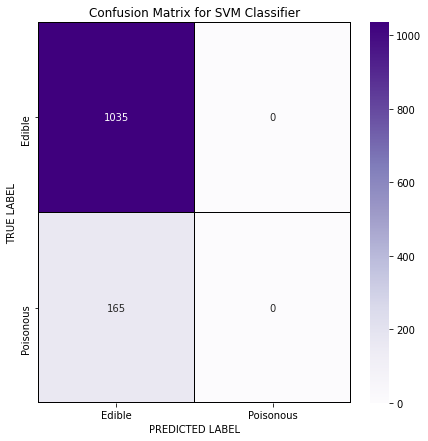

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for SVM Classifier')
#plt.savefig("svmcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

# 가우시안

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
print("Test Accuracy: {}%".format(round(nb.score(X_test, y_test)*100, 2)))


Test Accuracy: 14.83%


In [ ]:
y_pred_nb = nb.predict(X_test)
print("Naive Bayes Classifier report: \n\n", classification_report(y_test, y_pred_nb))

Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.84      0.02      0.03      1035
           1       0.14      0.98      0.24       165

    accuracy                           0.15      1200
   macro avg       0.49      0.50      0.14      1200
weighted avg       0.75      0.15      0.06      1200



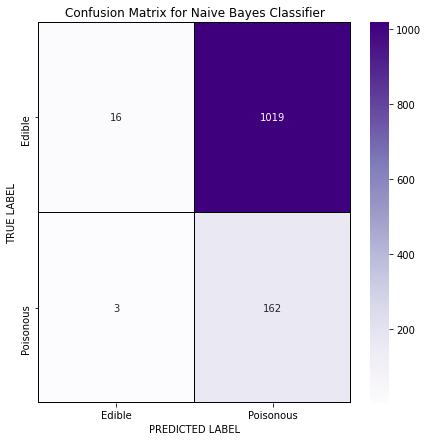

In [ ]:
cm = confusion_matrix(y_test, y_pred_nb)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Naive Bayes Classifier')
#plt.savefig("nbcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

# 랜덤트리포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Test Accuracy: {}%".format(round(rf.score(X_test, y_test)*100, 2)))

Test Accuracy: 84.92%


In [ ]:
y_pred_rf = rf.predict(X_test)
print("Random Forest Classifier report: \n\n", classification_report(y_test, y_pred_rf))

Random Forest Classifier report: 

               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1035
           1       0.29      0.07      0.11       165

    accuracy                           0.85      1200
   macro avg       0.58      0.52      0.51      1200
weighted avg       0.79      0.85      0.81      1200



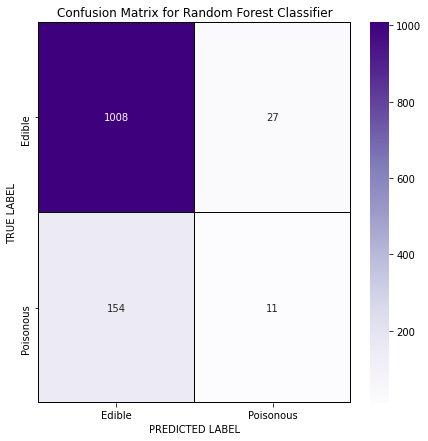

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Random Forest Classifier');
#plt.savefig("rfcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

### 테스트 하는 곳

In [ ]:
all_words_df2

,Node.js,HTML,MongoDB,JavaScript,None,Java,OracleDatabase,Spring,Python,MySQL,...,NoSQL,OpenCV,Pandas,R,RaspberryPi,Retrofit,SQLAlchemy,SpringDataJPA,web3.js,Size
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2432,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [ ]:
# print(y_pred_knn[:36])
# print(y_test[:36].values)
# 0 - Edible
# 1 - Poisonous
y_pred_dt = dt.predict(all_words_df2) #의사결정 트리
y_pred_lr = lr.predict(all_words_df2) #선형
y_pred_knn = knn.predict(all_words_df2) #knn
y_pred_svm = svm.predict(all_words_df2) #svm
y_pred_nb = nb.predict(all_words_df2) #가우시안
y_pred_rf = rf.predict(all_words_df2) #랜덤 포레스트
 



In [ ]:
ss = pd.read_csv('./data/test_job.csv')
ss['applied'] = list(y_pred_dt)
ss['applied'].to_csv('./right_의사결정.csv',index=False)
ss['applied'] = list(y_pred_lr)
ss['applied'].to_csv('./right_선형회귀.csv',index=False)
ss['applied'] = list(y_pred_knn)
ss['applied'].to_csv('./right_knn.csv',index=False)
ss['applied'] = list(y_pred_svm)
ss['applied'].to_csv('./right_svm.csv',index=False)
ss['applied'] = list(y_pred_nb)
ss['applied'].to_csv('./right_nb.csv',index=False)
ss['applied'] = list(y_pred_rf)
ss['applied'].to_csv('./right_랜덤포레.csv',index=False)